<a href="https://colab.research.google.com/github/epochee/Angle-Prediction/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **데이터 레이블링**




In [1]:
import cv2
import os

In [ ]:
for j in range(0,360):      # 주어진 데이터를 1도씩 돌려 360개의 레이블링                  
  path = '/content/drive/MyDrive/data/train'
  path2 = '/content/drive/MyDrive/t_v_data/train/'
  file_list = os.listdir(path)
  file_list_py = [file for file in file_list if file.endswith('.png')]
  a=0
  new_dir = os.mkdir(path2+str(j))
  for i in file_list_py:
    image = cv2.imread(path+'/'+i)
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),j,0.57)
    dst = cv2.warpAffine(image,M,(cols,rows), None, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT, (255,255,255))
    gray_array = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(gray_array, ksize=(5, 5), sigmaX=0) #가우시안블러를 통해 노이즈제거 효과

    img_thresh = cv2.adaptiveThreshold(  #쓰레쉬홀드로 이진화
        img_blurred, 
        maxValue=255.0, 
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        thresholdType=cv2.THRESH_BINARY, 
        blockSize=19, 
        C=9
    )
    cv2.imwrite(path2+str(j),img_thresh) # 이미지 이진화 후 저장
    a+=1
    if a == 2000: 
      break



In [ ]:
for j in range(0,360):
  path = '/content/drive/MyDrive/data/train'
  path2 = '/content/drive/MyDrive/t_v_data/val/'
  file_list = os.listdir(path)
  file_list_py = [file for file in file_list if file.endswith('.png')]
  new_dir = os.mkdir(path2+str(j))
  file_list_py = file_list_py.reverse() # train 데이터와 중복되지않기위해서 file리스트 뒤집기
  a=0
  for i in file_list_py:
    image = cv2.imread(path+'/'+i)
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),j,0.57)
    dst = cv2.warpAffine(image,M,(cols,rows), None, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT, (255,255,255))
    gray_array = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    img_blurred = cv2.GaussianBlur(gray_array, ksize=(5, 5), sigmaX=0)

    img_thresh = cv2.adaptiveThreshold(
        img_blurred, 
        maxValue=255.0, 
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        thresholdType=cv2.THRESH_BINARY_INV, 
        blockSize=19, 
        C=9
    )
    cv2.imwrite(path2+str(j),img_thresh)
    a+=1
    if a==500:
      break


이미지 전처리 및 vgg16모델 학습

In [ ]:
from google.colab.patches import cv2_imshow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras import layers
from keras.preprocessing import image
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16	
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img,ImageDataGenerator

In [ ]:
base_dir = '/content/drive/MyDrive/data_8_o'
train_dir = os.path.join(base_dir,'train')
val_dir = os.path.join(base_dir,'val')

In [ ]:
classes = os.listdir(train_dir)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(      # 이미지 증강
    width_shift_range = 0.2,  
    height_shift_range = 0.2,
    zoom_range = 0.2,
    rescale = 1. / 255,
    fill_mode='nearest')


img_path='/content/drive/MyDrive/train_val_data/train/0/000978.png.png'          
img = load_img(img_path,target_size=(224,224))
x = img_to_array(img)
x = x.reshape((1, )+x.shape)


i = 0   
for batch in generator.flow(x,batch_size=1):                            # 증강시킨 이미지 보기
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i+=1
  if i%10==0:
    break

In [ ]:
input_shape = (224,224,3) # vgg16 input_shape

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(     # 이미지 증강
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    rescale = 1. / 255,
    fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1. / 255,
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow import keras

In [ ]:
vgg = VGG16(weights='imagenet',input_shape=input_shape,include_top=False)  #vgg16 전이학습
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = True
set_trainable = False
# ,'block4_conv1'
for layer in vgg_model.layers:              # 전이학습 가중치 미세튜닝(마지막블록 가중치학습가능하게만듬)
  if layer.name in ['block5_conv1']:
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
import pandas as pd 

layers = [(layer, layer.name, layer. trainable)for layer in vgg_model.layers]  # 가중치 학습 가능한 레이어보기
pd.DataFrame(layers, columns=['Type','Name', 'Trainable'])

,Type,Name,Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_9,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [ ]:
#모델학습

model = Sequential()
model.add(vgg_model)
model.add(Dense(512,input_dim=input_shape, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(360,activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(3e-4),
              metrics=['accuracy'])

In [ ]:
history_o = model.fit_generator(train_generator,
                    epochs=20,
                    validation_data=val_generator,
                    verbose=1)

# **시각화**

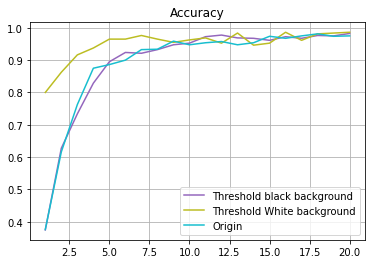

In [ ]:
accuracy_t_b = history_t_b.history['accuracy']
val_accuracy_t_b = history_t_b.history['val_accuracy']
loss_t_b = history_t_b.history['loss']
val_loss_t_b = history_t_b.history['val_loss']
accuracy_t_w = history_t_w.history['accuracy']
val_accuracy_t_w = history_t_w.history['val_accuracy']
loss_t_w = history_t_w.history['loss']
val_loss_t_w = history_t_w.history['val_loss']
accuracy_o = history_o.history['accuracy']
val_accuracy_o = history_o.history['val_accuracy']
loss_o = history_o.history['loss']
val_loss_o = history_o.history['val_loss']
epochs = range(1,len(accuracy_t_b)+1)

plt.plot(epochs,accuracy_t_b, 'C4', label='Threshold black background')
plt.plot(epochs,accuracy_t_w, 'C8', label='Threshold White background')
plt.plot(epochs,accuracy_o, 'C9', label='Origin')
plt.title('Accuracy')
plt.grid()
plt.legend()

# plt.figure()
# plt.plot(epochs,accuracy, 'b--', label='Train Accuracy')
# plt.plot(epochs,val_accuracy, 'r--', label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.grid()
# plt.legend()

plt.show()

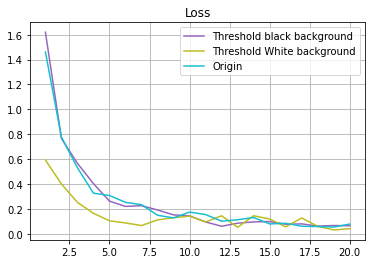

In [ ]:
plt.plot(epochs,loss_t_b, 'C4', label='Threshold black background')
plt.plot(epochs,loss_t_w, 'C8', label='Threshold White background')
plt.plot(epochs,loss_o, 'C9', label='Origin')
plt.title('Loss')
plt.grid()
plt.legend()

plt.show()

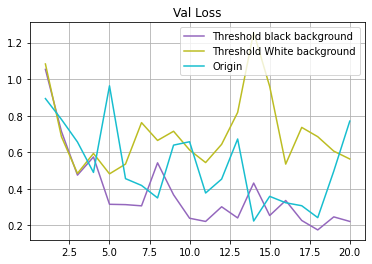

In [ ]:
plt.plot(epochs,val_loss_t_b, 'C4', label='Threshold black background')
plt.plot(epochs,val_loss_t_w, 'C8', label='Threshold White background')
plt.plot(epochs,val_loss_o, 'C9', label='Origin')
plt.title('Val Loss')
plt.grid()
plt.legend()

plt.show()

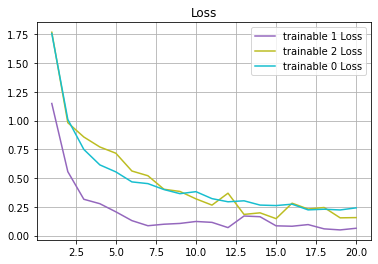

In [ ]:
plt.plot(epochs,accuracy_600, 'C4', label='600 size')
plt.plot(epochs,accuracy_448, 'C8', label='448 size')
plt.plot(epochs,accuracy_224, 'C9', label='224 size')
plt.title('Loss')
plt.grid()
plt.legend()

plt.show()

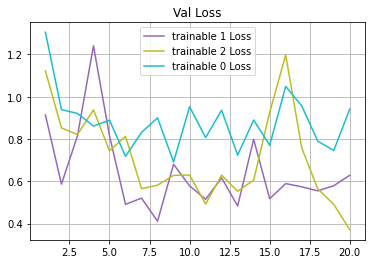

In [ ]:
plt.plot(epochs,accuracy_600, 'C4', label='600 size')
plt.plot(epochs,accuracy_448, 'C8', label='448 size')
plt.plot(epochs,accuracy_224, 'C9', label='224 size')
plt.title('Val Loss')
plt.grid()
plt.legend()

plt.show()

In [ ]:
model.save('vgg16_1.h5')  #모델을 편하게 사용하기위해 저장

# **모델 사용**

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model = load_model('/content/vgg16_1.h5')  # 저장한 모델가져오기

In [ ]:
img_path = '/content/drive/MyDrive/train_val_data/train/315/000978.png.png'
img = image.load_img(img_path,target_size=(224,224))
img_arr = image.img_to_array(img)
img_arr = img_arr[np.newaxis, ...]
img_arr /= 255.

print(img_arr.shape)

predict_x=model.predict(img_arr) 
classes_x=np.argmax(predict_x,axis=1)
# print(predict_x)
print(classes_x)

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

test_img_path = '/content/drive/MyDrive/data/test_samples/test.png'

img = cv2.imread('/content/drive/MyDrive/data2/180/000019.png') # 영수증# 기본
gray_array = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blurred = cv2.GaussianBlur(gray_array, ksize=(5, 5), sigmaX=0) #가우시안블러를 통해 노이즈제거 효과

img_thresh = cv2.adaptiveThreshold(  #쓰레쉬홀드로 검은부분과 흰부분으로 나눔
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)


plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')
print(img_thresh)
print(img_thresh.shape)
cv2.imwrite(test_img_path,img_thresh)


img = image.load_img(test_img_path,target_size=(224,224))
img_arr = image.img_to_array(img)
img_arr = img_arr[np.newaxis, ...]
img_arr /= 255.

print(img_arr.shape)

predict_x=model.predict(img_arr) 
classes_x=np.argmax(predict_x,axis=1)
# print(predict_x)
print(classes_x)

os.remove(test_img_path)

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np


test_img_path = '/content/drive/MyDrive/data/test_samples/test.png'

img = cv2.imread('/content/drive/MyDrive/data/test_samples/easyset/3.png') # 영수증# 기본
gray_array = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blurred = cv2.GaussianBlur(gray_array, ksize=(5, 5), sigmaX=0) #가우시안블러를 통해 노이즈제거 효과

img_thresh = cv2.adaptiveThreshold(  #쓰레쉬홀드로 검은부분과 흰부분으로 나눔
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY, 
    blockSize=19, 
    C=9
)


plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')
print(img_thresh)
print(img_thresh.shape)

In [ ]:
import cv2

img = cv2.imread('/content/drive/MyDrive/data/test_samples/easyset/3.png') # 영수증# 기본
gray_array = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blurred = cv2.GaussianBlur(gray_array, ksize=(5, 5), sigmaX=0) #가우시안블러를 통해 노이즈제거 효과

ret,img_thresh = cv2.threshold(  #쓰레쉬홀드로 검은부분과 흰부분으로 나눔
    img_blurred, 
    95,
    255,
    cv2.THRESH_TOZERO
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')
print(img_thresh)
print(img_thresh.shape)

In [ ]:
img_path = '/content/drive/MyDrive/data4/135/000000.png'
img = cv2.imread(img_path)
img = cv2.resize(img,(300,300))
# img = image.load_img(img_path,target_size=(300,300))
gray_array = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blurred = cv2.GaussianBlur(gray_array, ksize=(5, 5), sigmaX=0) #가우시안블러를 통해 노이즈제거 효과

img_thresh = cv2.adaptiveThreshold(  #쓰레쉬홀드로 검은부분과 흰부분으로 나눔
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

img_arr = image.img_to_array(img_thresh)
# img_arr = tf.image.rgb_to_grayscale(img_arr)
img_arr = img_arr[np.newaxis, ...]
img_arr /= 255.

print(img_arr.shape)

predict_x=model.predict(img_arr) 
classes_x=np.argmax(predict_x,axis=1)
# print(predict_x)
print(classes_x)

In [ ]:
predict_x=model.predict(img_arr) 
classes_x=np.argmax(predict_x,axis=1)

In [ ]:
classes_x